In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('C:/All Programming/Phitron/Machine learning/Books and dataset/Dataset/Public-Datasets/satellite.csv')
df.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute28,Attribute29,Attribute30,Attribute31,Attribute32,Attribute33,Attribute34,Attribute35,Attribute36,Class
0,80,102,102,79,76,102,102,79,76,102,...,87,79,107,109,87,79,107,113,87,3
1,76,102,102,79,76,102,106,83,76,102,...,87,79,107,113,87,79,103,104,83,3
2,80,98,106,79,76,94,102,76,76,94,...,79,79,95,100,79,79,95,96,75,4
3,76,94,102,76,76,94,102,76,76,94,...,79,79,95,96,75,79,95,100,75,4
4,76,94,102,76,76,94,102,76,76,89,...,75,79,95,100,75,75,95,100,79,4


In [7]:
print(f"Shape: {df.shape}")
print(pd.Series(df['Class']).value_counts(normalize=True))

Shape: (6435, 37)
Class
1    0.238228
7    0.234343
3    0.211033
5    0.109868
2    0.109246
4    0.097280
Name: proportion, dtype: float64


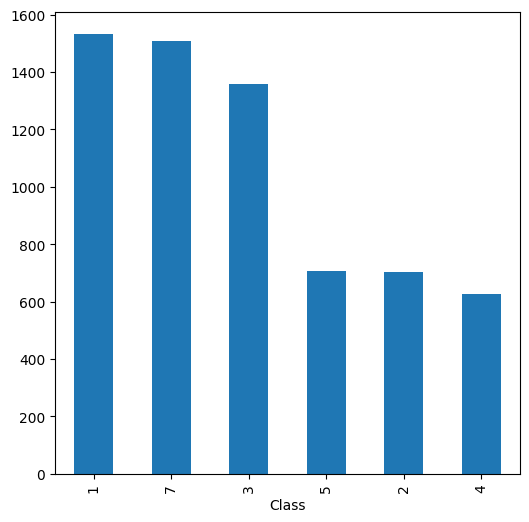

In [5]:
plt.figure(figsize=(6, 6))
df['Class'].value_counts().plot(kind='bar')
plt.show()

**Split Features and Target**

In [14]:
x = df.drop('Class', axis=1)
y = df['Class']

print(f"Features shape: {x.shape}")
print(f"Target shape: {y.shape}")
print(f'Class distribution: {y.value_counts().to_dict()}')

Features shape: (6435, 36)
Target shape: (6435,)
Class distribution: {1: 1533, 7: 1508, 3: 1358, 5: 707, 2: 703, 4: 626}


**Train-test split**

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, stratify=y, random_state=42)

print(f"Training set size: {x_train.shape[0]}")
print(f"Test set size: {x_test.shape[0]}")

print(f"\nTraining class distribution:\n", y_train.value_counts(normalize=True))
print(f"\nTest class distribution:\n", y_test.value_counts(normalize=True))

Training set size: 5148
Test set size: 1287

Training class distribution:
 Class
1    0.238151
7    0.234460
3    0.210956
5    0.109946
2    0.109169
4    0.097319
Name: proportion, dtype: float64

Test class distribution:
 Class
1    0.238539
7    0.233877
3    0.211344
5    0.109557
2    0.109557
4    0.097125
Name: proportion, dtype: float64


**Scaler and PCA**

In [31]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [32]:
pca = PCA(n_components=.95, random_state=42)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

print(pca.explained_variance_ratio_)

[0.45161164 0.39959855 0.04376371 0.02543283 0.01842376 0.01727836]


In [34]:
x_train_pca.shape

(5148, 6)

**Train Basic Models**

In [ ]:
base_models = {
    'Decision Tree' : DecisionTreeClassifier(random_state=42),
    'SVM' : SVC(probability=True, random_state=42),
    'KNN' : KNeighborsClassifier(n_neighbors=100),
    'Logistic Regression' : LogisticRegression(random_state=42)
}
results = {}

for name, model in base_models.items():
    print(f"Training {name} Model")
    
    model.fit(x_train_pca, y_train)
    
    y_pred = model.predict(x_test_pca)
    y_pred_proba = model.predict_proba(x_test_pca)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model' : model,
        'accuracy' : accuracy,
        'predictions' : y_pred,
        'probabilities' : y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))

**Train Ensemble Model**

In [61]:
basic_models = [
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('SVM', SVC(probability=True, random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=100)),
    ('Logistic Regression', LogisticRegression(random_state=42))
]

In [62]:
models = {
    'Random Forest' : RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost' : AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=42),
    'Gradient Boost' : GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Lgboost' : LGBMClassifier(n_estimators=100, random_state=42),
    'Bagging Classifier' : BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=42),
    'Stacking Classifier' : StackingClassifier(estimators=basic_models, final_estimator=DecisionTreeClassifier(random_state=42)),
    'Voting Classifier' : VotingClassifier(estimators=basic_models, voting='hard')
}
ensemble_results = {}

for name, model in models.items():
    print(f"Training {name} Model")
    
    model.fit(x_train_pca, y_train)
    
    y_pred = model.predict(x_test_pca)
    y_pred_proba = model.predict_proba(x_test_pca)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    ensemble_results[name] = {
        'model' : model,
        'accuracy' : accuracy,
        'predictions' : y_pred,
        'probabilities' : y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))

Training Random Forest Model
Accuracy: 0.908

Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.98      0.98       307
           2       0.97      0.96      0.97       141
           3       0.88      0.95      0.92       272
           4       0.74      0.61      0.67       125
           5       0.88      0.87      0.87       141
           7       0.89      0.91      0.90       301

    accuracy                           0.91      1287
   macro avg       0.89      0.88      0.88      1287
weighted avg       0.91      0.91      0.91      1287

Training AdaBoost Model
Accuracy: 0.814

Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.97      0.96       307
           2       0.99      0.93      0.96       141
           3       0.81      0.96      0.88       272
           4       0.52      0.18      0.26       125
           5       0.73      0.45      0.56       141

In [63]:
cv_results = {}

for name, model in models.items():

    scores = cross_val_score(model, x_train_pca, y_train, scoring='accuracy', cv=5, n_jobs=-1)
    
    cv_results[name] = {
        'mean' : scores.mean(),
        'std' : scores.std()
    }
    print(f"{name:20s}: {scores.mean():.3f} (+/- {scores.std():.3f})")

Random Forest       : 0.901 (+/- 0.006)
AdaBoost            : 0.804 (+/- 0.022)
Gradient Boost      : 0.891 (+/- 0.009)
Lgboost             : 0.903 (+/- 0.011)
Bagging Classifier  : 0.462 (+/- 0.002)
Stacking Classifier : 0.861 (+/- 0.010)
Voting Classifier   : 0.882 (+/- 0.008)



Confusion Matrix for Random Forest:


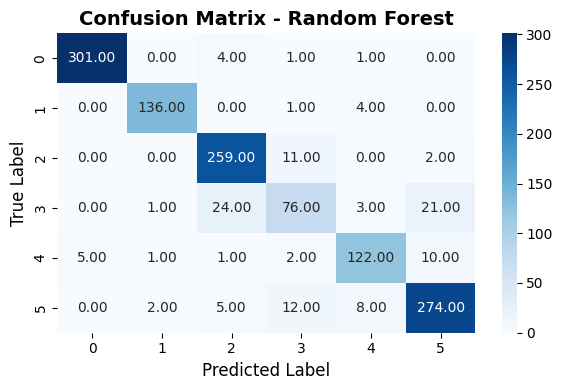

In [64]:
best_model_name = max(ensemble_results, key=lambda x: ensemble_results[x]['accuracy'])
best_model = ensemble_results[best_model_name]['model']
y_pred_best = ensemble_results[best_model_name]['predictions']
print(f"\nConfusion Matrix for {best_model_name}:")

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [65]:
comparison = pd.DataFrame({
    'Model': list(ensemble_results.keys()),
    'Accuracy': [ensemble_results[m]['accuracy'] for m in ensemble_results.keys()],
    'CV F1 Mean': [cv_results[m]['mean'] for m in ensemble_results.keys()],
    'CV F1 Std': [cv_results[m]['std'] for m in ensemble_results.keys()]
}).sort_values('Accuracy', ascending=False)

print(comparison)

                 Model  Accuracy  CV F1 Mean  CV F1 Std
0        Random Forest  0.907537    0.900740   0.005651
3              Lgboost  0.905983    0.902684   0.010842
2       Gradient Boost  0.890443    0.890638   0.008509
6    Voting Classifier  0.876457    0.882477   0.007801
5  Stacking Classifier  0.847708    0.860528   0.009540
1             AdaBoost  0.814297    0.804191   0.022476
4   Bagging Classifier  0.460761    0.461733   0.002438


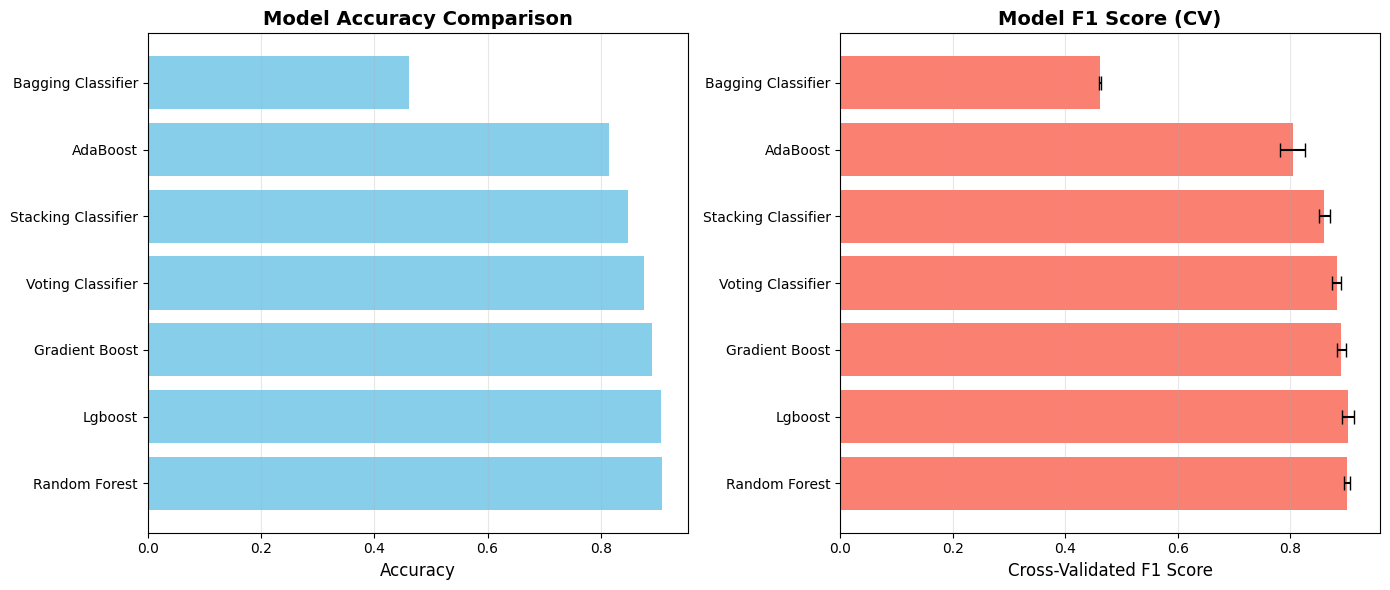

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].barh(comparison['Model'], comparison['Accuracy'], color='skyblue')
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)


axes[1].barh(comparison['Model'], comparison['CV F1 Mean'], 
             xerr=comparison['CV F1 Std'], color='salmon', capsize=5)
axes[1].set_xlabel('Cross-Validated F1 Score', fontsize=12)
axes[1].set_title('Model F1 Score (CV)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**HPO**

In [68]:
param_dist = {
    'n_estimators' : [50, 100, 150, 200],
    'max_depth': [5, 10, 20, None],
    'bootstrap': [True, False],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(rf, param_dist, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(x_train_pca, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'bootstrap': [True, False], 'max_depth': [5, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [70]:
print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_:.3f}")

best_model = grid.best_estimator_
y_pred_grid_best = best_model.predict(x_test_pca)
print(classification_report(y_test, y_pred_grid_best))

Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.904
              precision    recall  f1-score   support

           1       0.98      0.98      0.98       307
           2       0.98      0.96      0.97       141
           3       0.89      0.95      0.92       272
           4       0.78      0.66      0.71       125
           5       0.88      0.87      0.87       141
           7       0.90      0.92      0.91       301

    accuracy                           0.91      1287
   macro avg       0.90      0.89      0.89      1287
weighted avg       0.91      0.91      0.91      1287



In [ ]:
best_model.score(x_train_pca, y_train)

1.0

In [85]:
final_model = best_model
new_samples = x_test_pca[:10] 

predictions = final_model.predict(new_samples)
probabilities = final_model.predict_proba(new_samples)

print("Predictions on New Samples:")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    prob_class = max(prob)
    print(f"Class : {pred} (probability: {prob_class:.3f})")

Predictions on New Samples:
Class : 1 (probability: 1.000)
Class : 3 (probability: 0.405)
Class : 1 (probability: 1.000)
Class : 4 (probability: 0.580)
Class : 1 (probability: 1.000)
Class : 3 (probability: 0.985)
Class : 7 (probability: 0.885)
Class : 4 (probability: 0.840)
Class : 3 (probability: 1.000)
Class : 5 (probability: 0.990)


In [ ]:
joblib.dump(final_model, 'rf_model.pkl')
joblib.dump(pca, 'pca.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']